# Analyze sessions in batch from Phase 1 of AdaDrive (work in progress)

Using notebook 3d backend.

0 files missing from root.txt in /Users/schko/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/schko/mne_data/MNE-fsaverage-data/fsaverage
Reading labels from parcellation...
   read 82 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.PALS_B12_Brodmann.annot
   read 46 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.PALS_B12_Brodmann.annot
reading participant-level motor data
found cleaned epochs
Adding metadata with 5 columns
509 matching events found
No baseline correction applied
removing ovlerlapping motor trials, starting epoch count 6291
post removal epoch count 6218
Replacing existing metadata with 75 columns
Applying baseline correction (mode: mean)
\begin{tabular}{rrrr}
\toprule
 sub &  w\_opacities &  const &  p\_opacities \\
\midrule
  20 &        -0.63 &   0.80 &         0.00 \\
  14 &        -0.15 &   0.24 &         0.00 \\
  12 &        -1.06 &   0.96 &         0.00 \\
  22 &     

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 7809 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 2268.7 ms
Checking surface interior status for 10242 points...
    Found  2241/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 8001 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 8001 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 2260.6 ms

Setting up for EEG...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


Computing EEG at 20484 source locations (free orientations)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished.
Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished


    Using tolerance 6.1e-07 (2.2e-16 eps * 64 dim * 4.3e+07  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 326269
log-likelihood on unseen data (descending order):
   shrunk: -706.964
   diagonal_fixed: -794.575
   empirical: -338786.930
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 2.4e-07 (2.2e-16 eps * 64 dim * 1.7e+07  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors


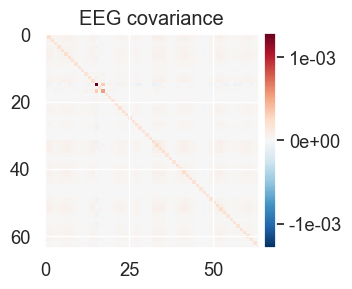

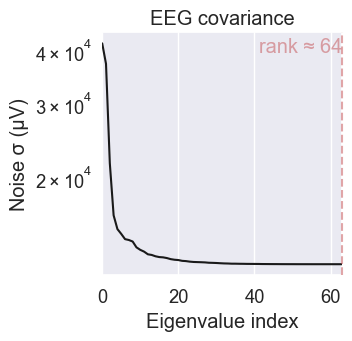

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.329337
    scale = 108975 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 64 dim * 1.5e+07  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD

In [1]:
%run 2-source.ipynb

## Evoked data by motor intensity

In [78]:
from mne_features.univariate import compute_pow_freq_bands
bands = [4, 8, 15, 32, 55]
band_intervals = list(zip(bands[:-1], bands[1:]))
eeg_channel_names = []
for i in range(len(rel_labels)):
    eeg_channel_names.append(f"{rel_mappings[rel_labels[i].name]}_{rel_labels[i].hemi}")
channel_band_power = [f"{chan_name}_{each_band[0]}-{each_band[1]}_Hz_Power"
                              for chan_name in eeg_channel_names
                                  for each_band in band_intervals]
band_power_all = np.empty([len(all_tcs), len(eeg_channel_names)*len(band_intervals)])
for i in range(len(all_tcs)):
    eeg_data = all_tcs[i,:]
    # Multitaper Method
    band_power = compute_pow_freq_bands(sfreq=128, data=eeg_data, freq_bands=band_intervals, normalize=True,
                                        psd_method = 'multitaper')
    band_power_all[i, :] = band_power
bpower_df = pd.DataFrame(band_power_all)
bpower_df.columns=channel_band_power
motor_epochs_metadata = motor_epochs.metadata.reset_index(drop=True)
motor_epochs_metadata = pd.concat([motor_epochs_metadata,bpower_df],axis=1)
motor_epochs_metadata = clean_up_trials(motor_epochs_metadata)
motor_epochs_metadata['motor_direction'] = motor_epochs_metadata.apply(lambda row: np.sign(row['post_steer_event_raw'][-1]-row['post_steer_event_raw'][0]),axis=1)
motor_epochs_metadata['motor_direction'] = motor_epochs_metadata.motor_direction.replace({-1: 0})


## Correlation analysis

In [83]:
all_source_powers = ['frontopolar_lh_4-8_Hz_Power', 'frontopolar_lh_8-15_Hz_Power', 'frontopolar_lh_15-32_Hz_Power', 'frontopolar_lh_32-55_Hz_Power', 'frontopolar_rh_4-8_Hz_Power', 'frontopolar_rh_8-15_Hz_Power', 'frontopolar_rh_15-32_Hz_Power', 'frontopolar_rh_32-55_Hz_Power', 'striate_lh_4-8_Hz_Power', 'striate_lh_8-15_Hz_Power', 'striate_lh_15-32_Hz_Power', 'striate_lh_32-55_Hz_Power', 'striate_rh_4-8_Hz_Power', 'striate_rh_8-15_Hz_Power', 'striate_rh_15-32_Hz_Power', 'striate_rh_32-55_Hz_Power', 'parastriate_lh_4-8_Hz_Power', 'parastriate_lh_8-15_Hz_Power', 'parastriate_lh_15-32_Hz_Power', 'parastriate_lh_32-55_Hz_Power', 'parastriate_rh_4-8_Hz_Power', 'parastriate_rh_8-15_Hz_Power', 'parastriate_rh_15-32_Hz_Power', 'parastriate_rh_32-55_Hz_Power', 'peristriate_lh_4-8_Hz_Power', 'peristriate_lh_8-15_Hz_Power', 'peristriate_lh_15-32_Hz_Power', 'peristriate_lh_32-55_Hz_Power', 'peristriate_rh_4-8_Hz_Power', 'peristriate_rh_8-15_Hz_Power', 'peristriate_rh_15-32_Hz_Power', 'peristriate_rh_32-55_Hz_Power', 'ventral_posterior_cingulate_lh_4-8_Hz_Power', 'ventral_posterior_cingulate_lh_8-15_Hz_Power', 'ventral_posterior_cingulate_lh_15-32_Hz_Power', 'ventral_posterior_cingulate_lh_32-55_Hz_Power', 'ventral_posterior_cingulate_rh_4-8_Hz_Power', 'ventral_posterior_cingulate_rh_8-15_Hz_Power', 'ventral_posterior_cingulate_rh_15-32_Hz_Power', 'ventral_posterior_cingulate_rh_32-55_Hz_Power', 'ventral_anterior_cingulate_lh_4-8_Hz_Power', 'ventral_anterior_cingulate_lh_8-15_Hz_Power', 'ventral_anterior_cingulate_lh_15-32_Hz_Power', 'ventral_anterior_cingulate_lh_32-55_Hz_Power', 'ventral_anterior_cingulate_rh_4-8_Hz_Power', 'ventral_anterior_cingulate_rh_8-15_Hz_Power', 'ventral_anterior_cingulate_rh_15-32_Hz_Power', 'ventral_anterior_cingulate_rh_32-55_Hz_Power', 'dorsal_posterior_cingulate_lh_4-8_Hz_Power', 'dorsal_posterior_cingulate_lh_8-15_Hz_Power', 'dorsal_posterior_cingulate_lh_15-32_Hz_Power', 'dorsal_posterior_cingulate_lh_32-55_Hz_Power', 'dorsal_posterior_cingulate_rh_4-8_Hz_Power', 'dorsal_posterior_cingulate_rh_8-15_Hz_Power', 'dorsal_posterior_cingulate_rh_15-32_Hz_Power', 'dorsal_posterior_cingulate_rh_32-55_Hz_Power', 'dorsal_anterior_cingulate_lh_4-8_Hz_Power', 'dorsal_anterior_cingulate_lh_8-15_Hz_Power', 'dorsal_anterior_cingulate_lh_15-32_Hz_Power', 'dorsal_anterior_cingulate_lh_32-55_Hz_Power', 'dorsal_anterior_cingulate_rh_4-8_Hz_Power', 'dorsal_anterior_cingulate_rh_8-15_Hz_Power', 'dorsal_anterior_cingulate_rh_15-32_Hz_Power', 'dorsal_anterior_cingulate_rh_32-55_Hz_Power', 'middle_frontal_lh_4-8_Hz_Power', 'middle_frontal_lh_8-15_Hz_Power', 'middle_frontal_lh_15-32_Hz_Power', 'middle_frontal_lh_32-55_Hz_Power', 'middle_frontal_rh_4-8_Hz_Power', 'middle_frontal_rh_8-15_Hz_Power', 'middle_frontal_rh_15-32_Hz_Power', 'middle_frontal_rh_32-55_Hz_Power', 'premotor_lh_4-8_Hz_Power', 'premotor_lh_8-15_Hz_Power', 'premotor_lh_15-32_Hz_Power', 'premotor_lh_32-55_Hz_Power', 'premotor_rh_4-8_Hz_Power', 'premotor_rh_8-15_Hz_Power', 'premotor_rh_15-32_Hz_Power', 'premotor_rh_32-55_Hz_Power', 'superior_parietal_lh_4-8_Hz_Power', 'superior_parietal_lh_8-15_Hz_Power', 'superior_parietal_lh_15-32_Hz_Power', 'superior_parietal_lh_32-55_Hz_Power', 'superior_parietal_rh_4-8_Hz_Power', 'superior_parietal_rh_8-15_Hz_Power', 'superior_parietal_rh_15-32_Hz_Power', 'superior_parietal_rh_32-55_Hz_Power', 'intermediate_frontal_lh_4-8_Hz_Power', 'intermediate_frontal_lh_8-15_Hz_Power', 'intermediate_frontal_lh_15-32_Hz_Power', 'intermediate_frontal_lh_32-55_Hz_Power', 'intermediate_frontal_rh_4-8_Hz_Power', 'intermediate_frontal_rh_8-15_Hz_Power', 'intermediate_frontal_rh_15-32_Hz_Power', 'intermediate_frontal_rh_32-55_Hz_Power', 'dlpfc_lh_4-8_Hz_Power', 'dlpfc_lh_8-15_Hz_Power', 'dlpfc_lh_15-32_Hz_Power', 'dlpfc_lh_32-55_Hz_Power', 'dlpfc_rh_4-8_Hz_Power', 'dlpfc_rh_8-15_Hz_Power', 'dlpfc_rh_15-32_Hz_Power', 'dlpfc_rh_32-55_Hz_Power']

In [85]:
from scipy.stats import spearmanr
motor_dfs_corr = motor_epochs_metadata[['Left Pupil Diameter','NSLR_mean_duration_Saccade','NSLR_count_Saccade','Abs_Steer_Wheel_Degree','density',
                            'bpm','rmssd','pnn50']+all_source_powers].dropna()
motor_dfs_corr['NSLR_mean_duration_Saccade'] *= 1000
motor_dfs_corr['Abs_Steer_Wheel_Degree'] *= 100
rho = motor_dfs_corr.corr(method='spearman')
pval = motor_dfs_corr.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho_df = rho.round(2).astype(str) + p
rename_dict = {'index':'measure','Abs_Steer_Wheel_Degree':'Motor intensity (deg)', 'density': 'Trial opacity',
               'NSLR_count_Saccade': 'Saccade count',
               'NSLR_mean_duration_Saccade': 'Saccade duration (ms)',
               '_4-8_Hz_Power': ' Theta',
              '_8-15_Hz_Power': ' Alpha',
               '_15-32_Hz_Power': ' Beta',
               '_32-55_Hz_Power': ' Gamma',
              'bpm':'BPM', 'rmssd':'RMSSD (ms)','pnn50':'PNN50','Left Pupil Diameter':'Pupil Diameter (mm)'
              }
rho_df = rho_df.reset_index().rename(columns=rename_dict).iloc[:,:9]
rho_df['measure'] = rho_df.measure.replace(rename_dict, regex=True)
rho_df = rho_df.append({'measure':'mean' ,'Saccade duration (ms)': np.mean(motor_dfs_corr.NSLR_mean_duration_Saccade),
               'Saccade count': np.mean(motor_dfs_corr.NSLR_count_Saccade),
              'Trial opacity': np.mean(motor_dfs_corr.density),
               'Motor intensity (deg)': np.mean(motor_dfs_corr.Abs_Steer_Wheel_Degree),
                        'BPM': np.mean(motor_dfs_corr.bpm),
                        'RMSSD (ms)': np.mean(motor_dfs_corr.rmssd),
                        'PNN50': np.mean(motor_dfs_corr.pnn50),
                        'Pupil Diameter (mm)': np.mean(motor_dfs_corr['Left Pupil Diameter'])
              },ignore_index=True)
display(rho_df)
print(rho_df.to_latex(index=False,float_format="{:0.2f}".format))

,measure,Pupil Diameter (mm),Saccade duration (ms),Saccade count,Motor intensity (deg),Trial opacity,BPM,RMSSD (ms),PNN50
0,Pupil Diameter (mm),1.0***,0.04,-0.01,0.09***,-0.02,0.09***,-0.06**,0.01
1,Saccade duration (ms),0.04,1.0***,-0.08**,-0.02,0.08**,-0.01,-0.08**,-0.04
2,Saccade count,-0.01,-0.08**,1.0***,-0.07**,-0.09***,0.02,-0.09***,-0.09***
3,Motor intensity (deg),0.09***,-0.02,-0.07**,1.0***,0.01,0.0,0.05,0.03
4,Trial opacity,-0.02,0.08**,-0.09***,0.01,1.0***,0.03,0.04,0.03
...,...,...,...,...,...,...,...,...,...
108,dlpfc_rh Theta,0.17***,0.04,0.03,-0.03,0.01,0.12***,-0.17***,-0.12***
109,dlpfc_rh Alpha,-0.05,-0.01,-0.02,-0.01,0.01,-0.05,0.05*,0.03
110,dlpfc_rh Beta,-0.24***,-0.03,-0.05*,0.0,0.05*,-0.21***,0.23***,0.19***
111,dlpfc_rh Gamma,-0.3***,-0.04,-0.05,0.01,0.05*,-0.21***,0.24***,0.19***


\begin{tabular}{lllllllll}
\toprule
                             measure & Pupil Diameter (mm) & Saccade duration (ms) & Saccade count & Motor intensity (deg) & Trial opacity &      BPM & RMSSD (ms) &    PNN50 \\
\midrule
                 Pupil Diameter (mm) &              1.0*** &                  0.04 &         -0.01 &               0.09*** &         -0.02 &  0.09*** &    -0.06** &     0.01 \\
               Saccade duration (ms) &                0.04 &                1.0*** &       -0.08** &                 -0.02 &        0.08** &    -0.01 &    -0.08** &    -0.04 \\
                       Saccade count &               -0.01 &               -0.08** &        1.0*** &               -0.07** &      -0.09*** &     0.02 &   -0.09*** & -0.09*** \\
               Motor intensity (deg) &             0.09*** &                 -0.02 &       -0.07** &                1.0*** &          0.01 &      0.0 &       0.05 &     0.03 \\
                       Trial opacity &               -0.02 &          

In [91]:
motor_epochs_metadata[['Left Pupil Diameter','NSLR_mean_duration_Saccade','NSLR_count_Saccade','Abs_Steer_Wheel_Degree','density',
                            'bpm','rmssd','pnn50']+all_source_powers].dropna().shape, motor_epochs_metadata.shape

((2067, 109), (5126, 182))

##  Predict motor intensity using PMC, exploitation-related data

In [ ]:
import statsmodels.api as sm
all_vars = ['Abs_Steer_Wheel_Degree','ppid',
            'Left Pupil Diameter',
            'Steer_Wheel_Degree_Encoded','Steer_Wheel_Degree'] + all_source_powers
predictors = ['Left Pupil Diameter'] + all_source_powers
print('shape before', motor_epochs_metadata.shape)
motor_dfs_nonnan = motor_epochs_metadata[all_vars].dropna()
print('shape after', motor_dfs_nonnan.shape)

md = sm.regression.mixed_linear_model.MixedLM(motor_dfs_nonnan['Abs_Steer_Wheel_Degree'],motor_dfs_nonnan[predictors],
                 groups=motor_dfs_nonnan["ppid"])
mdf = md.fit()
display(mdf.summary())
print(f"The features that significantly predict motor intensity are {list(np.array(predictors)[np.where(mdf.pvalues[:-1]<0.05)])}")

# note that where p<0.05 we can realiably expect they have some predictive power for motor data

shape before (5126, 182)
shape after (4871, 110)


/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Mixed Linear Model Regression Results
========================================================================================
Model:                    MixedLM       Dependent Variable:       Abs_Steer_Wheel_Degree
No. Observations:         4871          Method:                   REML                  
No. Groups:               10            Scale:                    0.0116                
Min. group size:          289           Log-Likelihood:           3753.2306             
Max. group size:          772           Converged:                Yes                   
Mean group size:          487.1                                                         
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
frontopolar_lh_4-8_Hz_Power                   -0.053    0.084 -0.633 0.527 -0.217  0.111
frontopolar_lh_8-15_Hz_Power                   0.256    0.114  2.256 0.024  0.034  0.479
frontopolar_lh_15-32_Hz_Power                  0.004    0.065  0.067 0.946 -0.122  0.131
frontopolar_lh_32-55_Hz_Power                 -0.043    0.064 -0.668 0.504 -0.167  0.082
frontopolar_rh_4-8_Hz_Power                   -0.003    0.078 -0.043 0.965 -0.156  0.149
frontopolar_rh_8-15_Hz_Power                  -0.048    0.110 -0.432 0.666 -0.264  0.169
frontopolar_rh_15-32_Hz_Power                 -0.001    0.057 -0.015 0.988 -0.113  0.111
frontopolar_rh_32-55_Hz_Power                 -0.007    0.056 -0.129 0.897 -0.116  0.102
striate_lh_4-8_Hz_Power                       -0.044    0.176 -0.251 0.801 -0.390  0.301
striate_lh_8-15_Hz_Power                       0.088    0.140  0.629 0.529 -0.186  0.362
striate_lh_15-32_Hz_Power                      0.045    0.098  0.456 0.648 -0.147  0.236
striate_lh_32-55_Hz_Power                      0.095    0.088  1.078 0.281 -0.078  0.269
striate_rh_4-8_Hz_Power                       -0.135    0.165 -0.817 0.414 -0.459  0.189
striate_rh_8-15_Hz_Power                       0.130    0.137  0.949 0.343 -0.139  0.399
striate_rh_15-32_Hz_Power                      0.020    0.096  0.211 0.833 -0.168  0.208
striate_rh_32-55_Hz_Power                     -0.126    0.084 -1.501 0.133 -0.290  0.038
parastriate_lh_4-8_Hz_Power                   -0.088    0.178 -0.494 0.621 -0.437  0.261
parastriate_lh_8-15_Hz_Power                  -0.014    0.148 -0.095 0.924 -0.304  0.276
parastriate_lh_15-32_Hz_Power                  0.003    0.101  0.027 0.979 -0.196  0.201
parastriate_lh_32-55_Hz_Power                 -0.087    0.088 -0.986 0.324 -0.260  0.086
parastriate_rh_4-8_Hz_Power                    0.032    0.154  0.210 0.834 -0.270  0.335
parastriate_rh_8-15_Hz_Power                  -0.140    0.141 -0.996 0.319 -0.417  0.136
parastriate_rh_15-32_Hz_Power                 -0.125    0.099 -1.261 0.207 -0.320  0.069
parastriate_rh_32-55_Hz_Power                  0.143    0.086  1.678 0.093 -0.024  0.311
peristriate_lh_4-8_Hz_Power                    0.125    0.085  1.480 0.139 -0.041  0.291
peristriate_lh_8-15_Hz_Power                   0.001    0.073  0.018 0.985 -0.142  0.145
peristriate_lh_15-32_Hz_Power                 -0.014    0.049 -0.285 0.776 -0.110  0.082
peristriate_lh_32-55_Hz_Power                 -0.006    0.044 -0.127 0.899 -0.091  0.080
peristriate_rh_4-8_Hz_Power                    0.079    0.080  0.985 0.325 -0.078  0.237
peristriate_rh_8-15_Hz_Power                   0.055    0.070  0.791 0.429 -0.081  0.191
peristriate_rh_15-32_Hz_Power                  0.060    0.050  1.194 0.232 -0.038  0.157
peristriate_rh_32-55_Hz_Power                 -0.079    0.043 -1.834 0.067 -0.164  0.005
ventral_posterior_cingulate_lh_4-8_Hz_Power    0.091    0.078  1.171 0.242 -0.062  0.244
ventral_posterior_cingulate_lh_8-15_Hz_Power  -0.083    0.070

The features that significantly predict motor intensity are ['frontopolar_lh_8-15_Hz_Power', 'dorsal_posterior_cingulate_lh_15-32_Hz_Power', 'middle_frontal_rh_15-32_Hz_Power', 'superior_parietal_lh_8-15_Hz_Power', 'Left Pupil Diameter']


# Trial data accuracy

In [4]:
from sklearn.inspection import permutation_importance
import scipy.stats as st
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import time
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score

def rf_prediction_importances(input_df, prediction, predictors,pred_type = 'classification', calc_importances=True, seed=None, plot=True):
    prediction = prediction
    predictors = predictors

    # drop na
    motor_dfs_nonnan = input_df[predictors+[prediction]].dropna()
    print(f"size of dataset {motor_dfs_nonnan.shape} lost {len(input_df)-len(motor_dfs_nonnan)} trials or {(len(input_df)-len(motor_dfs_nonnan))/len(input_df)} as a result of removing nan values given the predictors")

    y = motor_dfs_nonnan[prediction]
    X = motor_dfs_nonnan[predictors]
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=seed)
    feature_names = list(X.columns)
    if pred_type == 'classification':
        forest = RandomForestClassifier(random_state=seed)
    elif pred_type == 'regression':
        forest = RandomForestRegressor(random_state=seed)
    forest.fit(X_train, y_train)

    # results
    if pred_type == 'classification':
        print(f"Class 1 proportion in training dataset {(y_train==1).sum()/len(y_train)}")
        print(f"Test AUC: {roc_auc_score(y_test, forest.predict_proba(X_test)[:,1])} Accuracy: {accuracy_score(y_test, forest.predict(X_test))}")
    elif pred_type == 'regression':
        print(f"Test R2: {r2_score(y_test, forest.predict(X_test))}")
    # importances
    if calc_importances:
        start_time = time.time()
        importances = forest.feature_importances_
        data = [tree.feature_importances_ for tree in forest.estimators_]
        cis = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data,axis=0), scale=st.sem(data))
        std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
        elapsed_time = time.time() - start_time

        print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
        forest_importances = pd.Series(importances, index=feature_names)
        if plot:
            fig, ax = plt.subplots(figsize=(32,16))
            forest_importances.plot.bar(yerr=cis[1]-cis[0], ax=ax)
            ax.set_title("Feature importances using MDI")
            ax.set_ylabel("Mean decrease in impurity")
            fig.tight_layout()

    if calc_importances:
        start_time = time.time()
        result = permutation_importance(
            forest, X_train, y_train, n_repeats=100, random_state=seed, n_jobs=2 # using training set
        )
        elapsed_time = time.time() - start_time
        print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
        data = result.importances.T
        cis = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data,axis=0), scale=st.sem(data))

        forest_importances = pd.Series(result.importances_mean, index=feature_names)
        forest_importances = np.clip(forest_importances,0,None) # clip the importances at 0 minimum so it makes sense, only relevant for small DFs
        if plot:
            fig, ax = plt.subplots(figsize=(32,16))
            forest_importances.plot.bar(yerr=cis[1]-cis[0], ax=ax)
            ax.set_title("Feature importances using permutation on full model")
            if pred_type == 'classification':
                ax.set_ylabel("Mean training accuracy decrease")
            elif pred_type == 'regression':
                ax.set_ylabel("Mean training R2 decrease")
            fig.tight_layout()
            plt.show()

# Motor prediction importances

size of dataset (4871, 104) lost 255 trials or 0.049746390948107684 as a result of removing nan values given the predictors
Class 1 proportion in training dataset 0.4905557076375582
Test AUC: 0.5108552338890372 Accuracy: 0.5114942528735632
Elapsed time to compute the importances: 0.006 seconds


KeyboardInterrupt: 

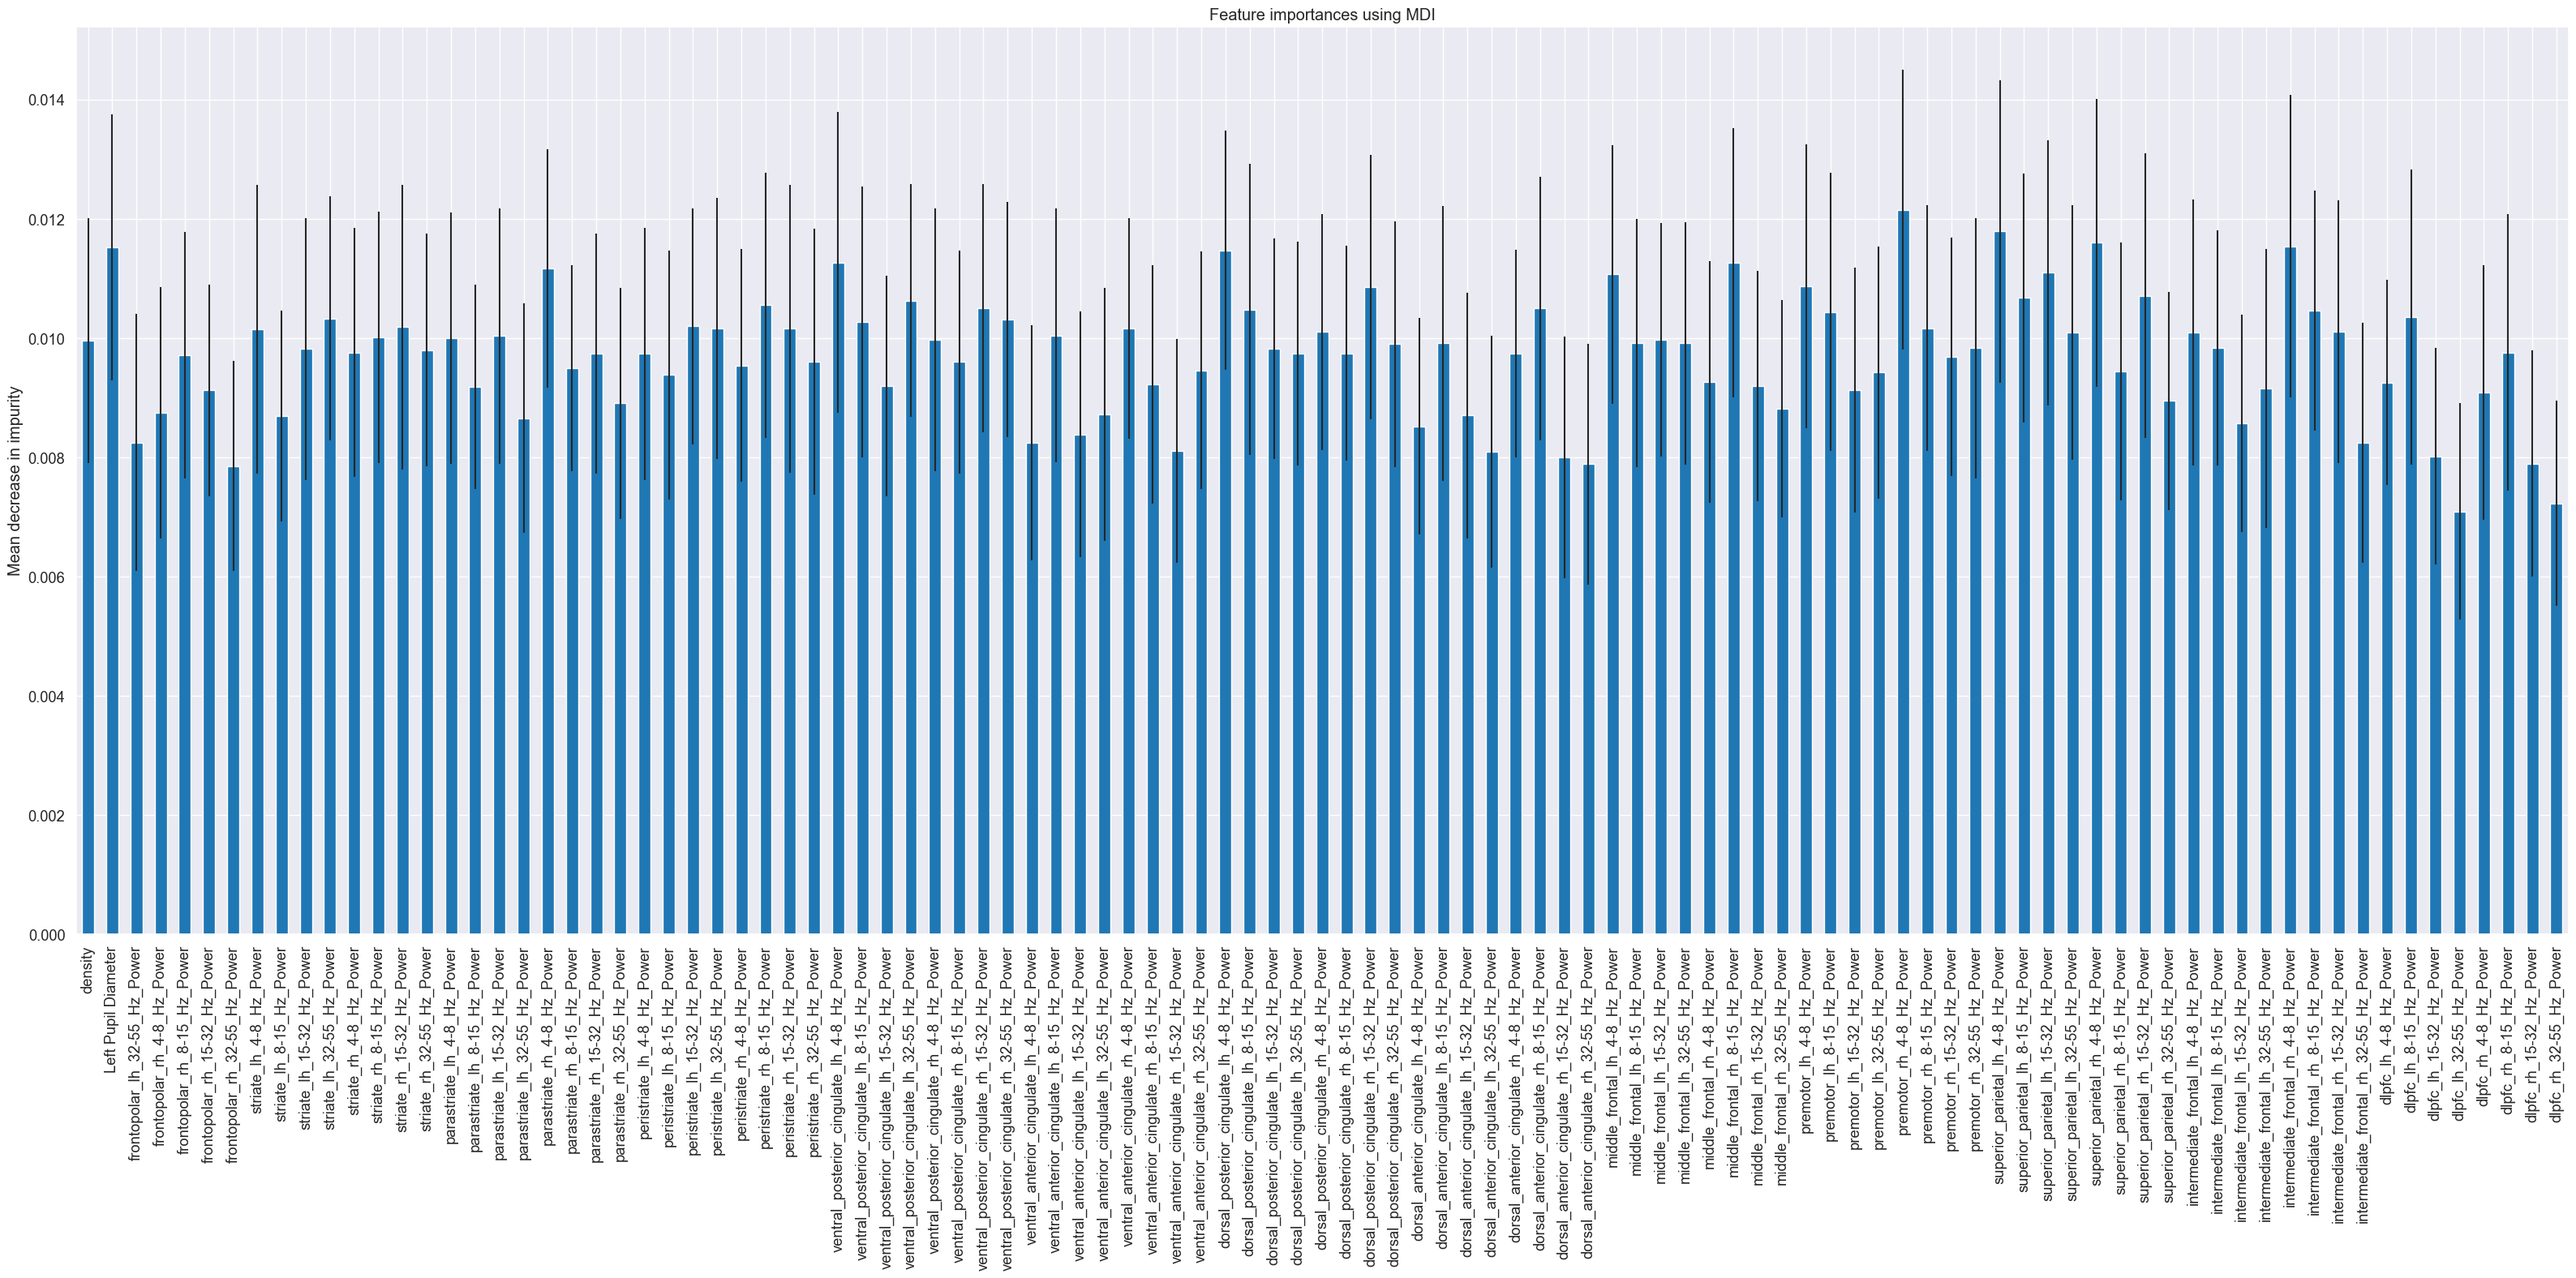

In [80]:
prediction = 'motor_direction'
predictors = ['density', 'Left Pupil Diameter'] + list(motor_epochs_metadata.columns[-104:-3])

# filter rows
motor_dfs_filtered = motor_epochs_metadata.copy()
rf_prediction_importances(motor_dfs_filtered, prediction, predictors, seed=42, calc_importances=True, plot=True)

size of dataset (2598, 22) lost 88 trials or 0.03276247207743857 as a result of removing nan values given the predictors
Test R2: -0.019226492706976295
Elapsed time to compute the importances: 0.006 seconds


KeyboardInterrupt: 

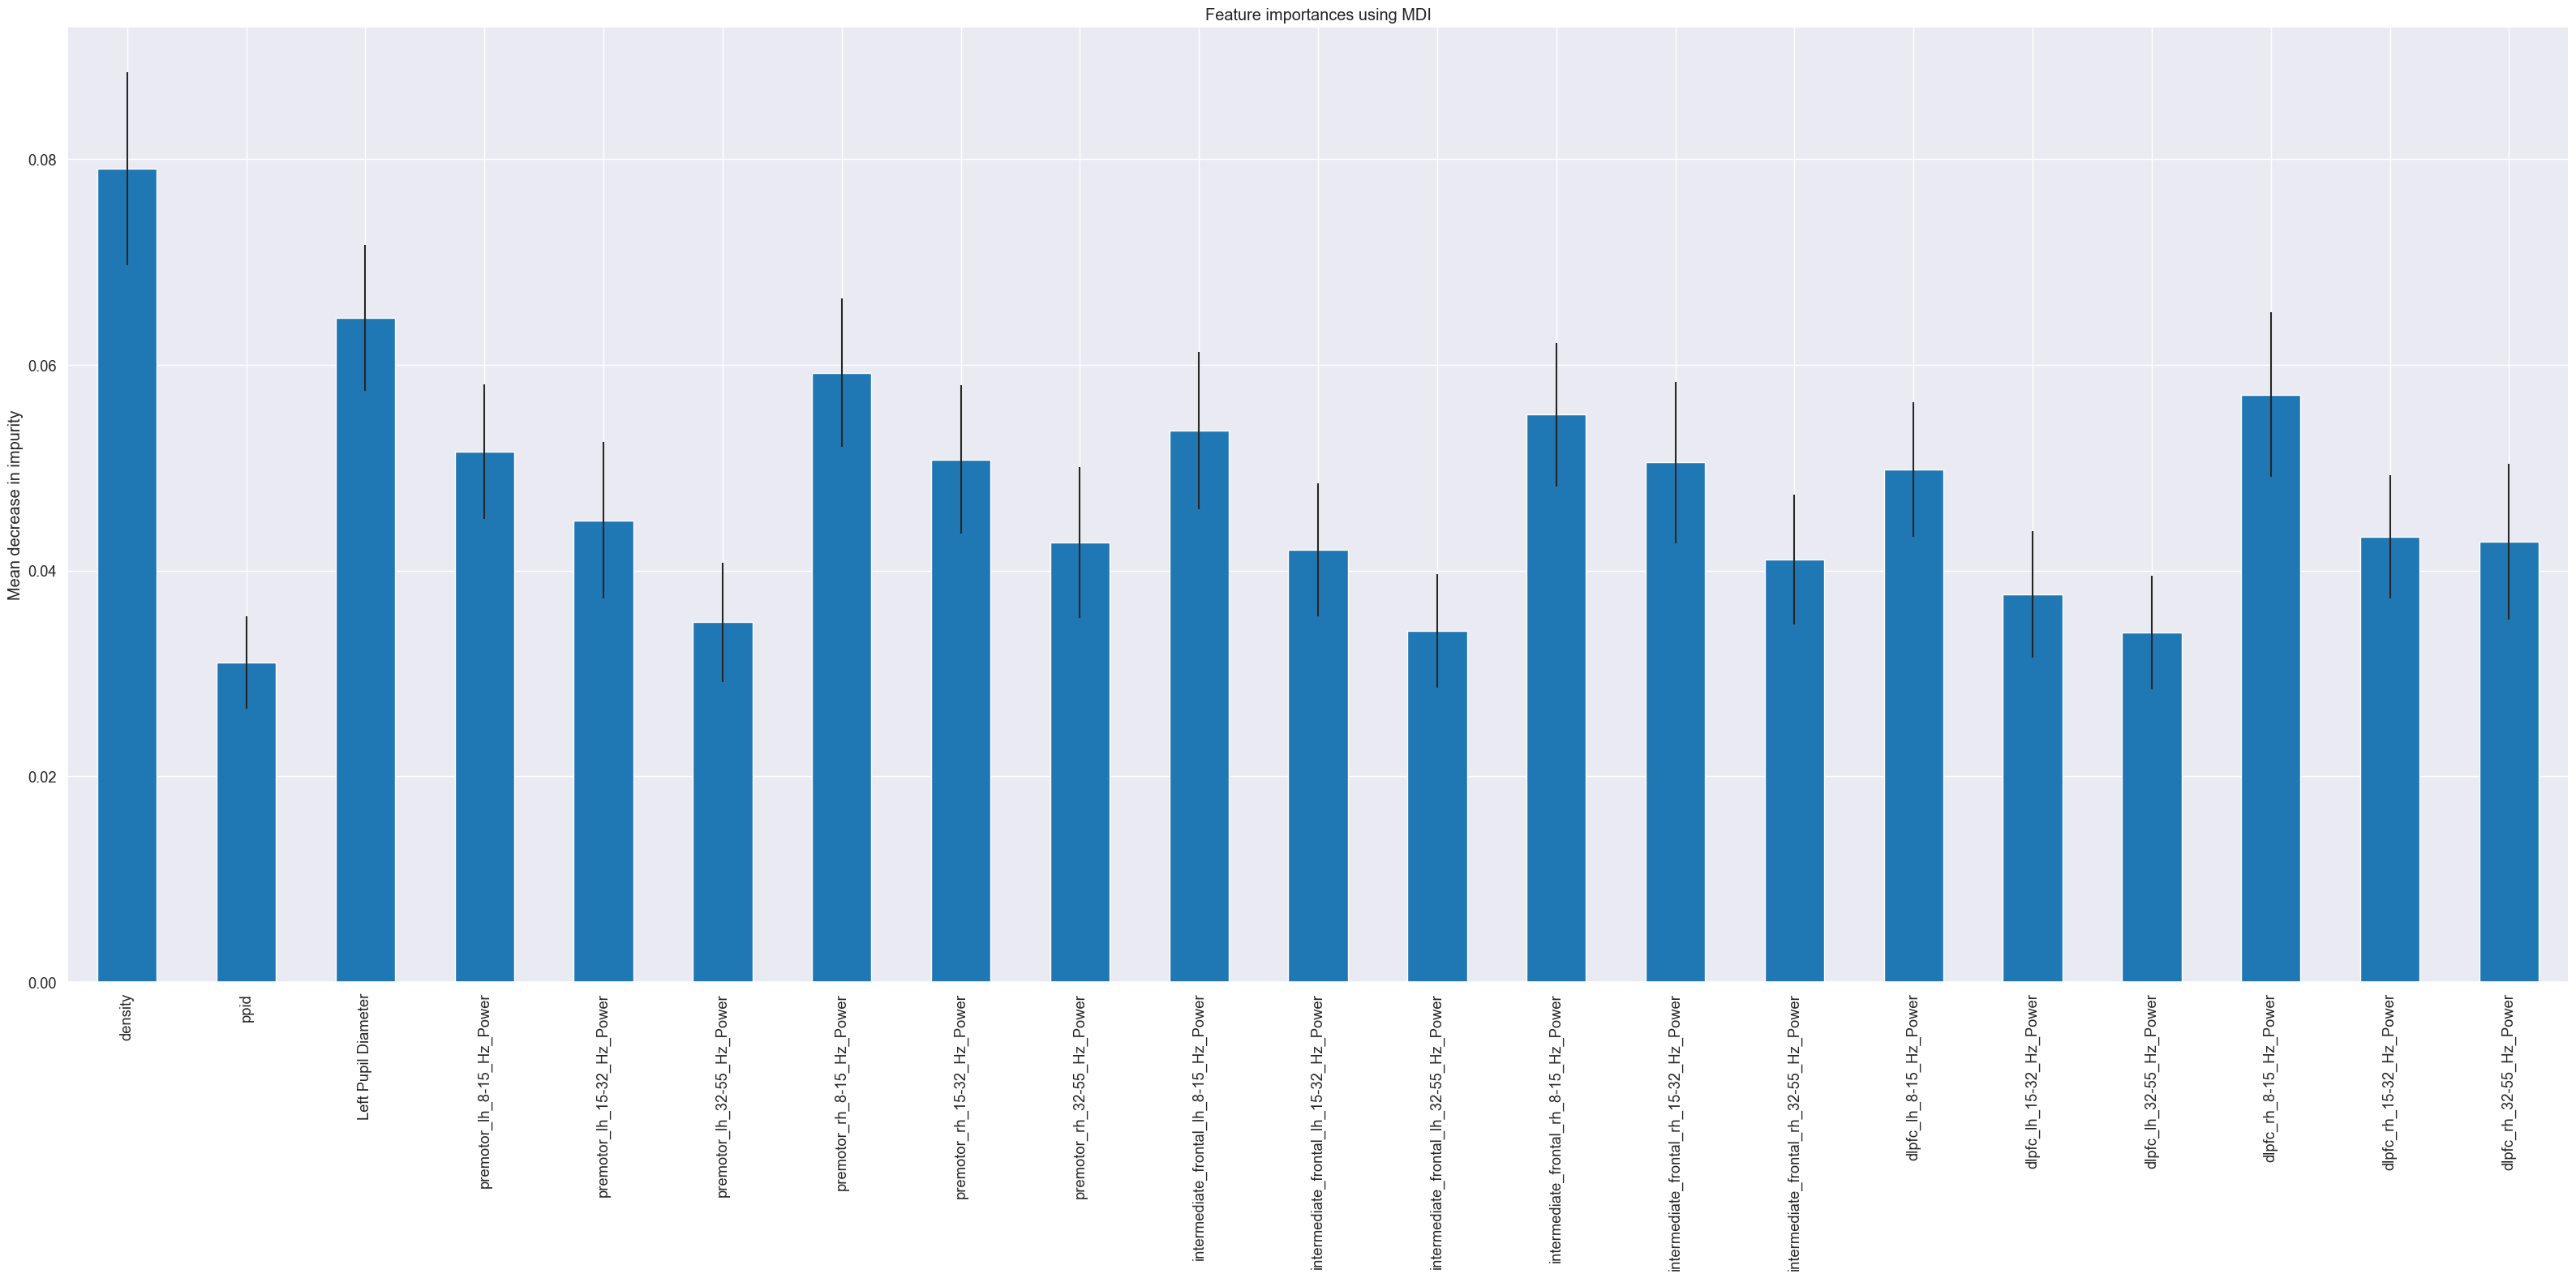

In [6]:
prediction = 'Abs_Steer_Wheel_Degree'
predictors = ['density', 'ppid','Left Pupil Diameter','premotor_lh_8-15_Hz_Power', 'premotor_lh_15-32_Hz_Power',
            'premotor_lh_32-55_Hz_Power', 'premotor_rh_8-15_Hz_Power',
            'premotor_rh_15-32_Hz_Power', 'premotor_rh_32-55_Hz_Power',
            'intermediate_frontal_lh_8-15_Hz_Power', 'intermediate_frontal_lh_15-32_Hz_Power',
            'intermediate_frontal_lh_32-55_Hz_Power',
            'intermediate_frontal_rh_8-15_Hz_Power', 'intermediate_frontal_rh_15-32_Hz_Power',
            'intermediate_frontal_rh_32-55_Hz_Power', 'dlpfc_lh_8-15_Hz_Power',
            'dlpfc_lh_15-32_Hz_Power', 'dlpfc_lh_32-55_Hz_Power', 'dlpfc_rh_8-15_Hz_Power',
            'dlpfc_rh_15-32_Hz_Power', 'dlpfc_rh_32-55_Hz_Power']

# filter rows
motor_dfs_filtered = motor_epochs_metadata.copy()
motor_dfs_filtered = motor_dfs_filtered[motor_dfs_filtered.spoken_difficulty != 'unknown']
rf_prediction_importances(motor_dfs_filtered, prediction, predictors, seed=42, pred_type='regression', calc_importances=True, plot=True)

## Simple t-test showing differences in DLPFC average activity between low and high conditions

In [ ]:
low_tcs = all_tcs[(motor_epochs.metadata.Steer_Wheel_Degree_Categorical == 'Low')]
high_tcs = all_tcs[(motor_epochs.metadata.Steer_Wheel_Degree_Categorical == 'High')]
        

for i in range(low_tcs.shape[1]):
    print(rel_mappings[rel_labels[i].name])
    trial_area_mean = low_tcs.mean(axis=2)
    trial_area_std = low_tcs.std(axis=2)
    sub_low_tcs = []
    for j in range(len(low_tcs)):
        sub_low_tcs.append((low_tcs[j,i]-trial_area_mean[j,i])/trial_area_std[j,i])

    h_trial_area_mean = high_tcs.mean(axis=2)
    h_trial_area_std = high_tcs.std(axis=2)
    sub_high_tcs = []
    for j in range(len(high_tcs)):
        sub_high_tcs.append((high_tcs[j,i]-h_trial_area_mean[j,i])/h_trial_area_std[j,i])
    
    print(scipy.stats.ttest_ind(np.array(sub_low_tcs).mean(axis=1), np.array(sub_high_tcs).mean(axis=1)))


# Cluster test

In [ ]:
evokeds_iterable = dict()

query = "Steer_Wheel_Degree_Categorical == '{}'"

for cond in motor_epochs.metadata['Steer_Wheel_Degree_Categorical'].unique():
    evokeds_iterable[str(cond)] = list(motor_epochs[query.format(cond)].iter_evoked())
mne.combine_evoked([low_motor_sensor.average(), high_motor_sensor.average()],
                            weights=[1, -1]).plot()
mne.combine_evoked([low_motor_avg, high_motor_avg],
                            weights=[1, -1]).plot()


In [ ]:
low_motor_data = [l.get_data() for l in low_motor]
low_motor_data = np.array(low_motor_data)
high_motor_data = [l.get_data() for l in high_motor]
high_motor_data = np.array(high_motor_data)
low_motor_avg = mne.combine_evoked(low_motor,weights='equal')
high_motor_avg = mne.combine_evoked(high_motor,weights='equal')

In [ ]:
significant_points = cluster_pv.reshape(t_obs.shape).T < .3
print(str(significant_points.sum()) + " points selected by TFCE ...")

In [ ]:
from mne.channels import find_ch_adjacency, make_1020_channel_selections
from mne.stats import spatio_temporal_cluster_test
# Calculate adjacency matrix between sensors from their locations
adjacency, _ = find_ch_adjacency(motor_epochs.info, "eeg")

# Extract data: transpose because the cluster test requires channels to be last
# In this case, inference is done over items. In the same manner, we could
# also conduct the test over, e.g., subjects.
X = [low_motor_data.transpose(0, 2, 1),
     high_motor_data.transpose(0, 2, 1)]
tfce = dict(start=.4, step=.4)  # ideally start and step would be smaller

# Calculate statistical thresholds
t_obs, clusters, cluster_pv, h0 = spatio_temporal_cluster_test(
    X, threshold=tfce, adjacency=adjacency,
    n_permutations=100, n_jobs = 5)  # a more standard number would be 1000+
significant_points = cluster_pv.reshape(t_obs.shape).T < .05
print(str(significant_points.sum()) + " points selected by TFCE ...")

# We need an evoked object to plot the image to be masked
evoked = mne.combine_evoked([low_motor_avg, high_motor_avg],
                            weights=[1, -1])  # calculate difference wave
time_unit = dict(time_unit="s")
evoked.plot_joint(title="Long vs. short words", ts_args=time_unit,
                  topomap_args=time_unit)  # show difference wave

# Create ROIs by checking channel labels
selections = make_1020_channel_selections(evoked.info, midline="12z")

# Visualize the results
fig, axes = plt.subplots(nrows=3, figsize=(8, 8))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
evoked.plot_image(axes=axes, group_by=selections, colorbar=False, show=False,
                  mask=significant_points, show_names="all", titles=None,
                  **time_unit)
plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=.3,
             label="µV")

plt.show()

## Source permutation t-tests with clustering

In [ ]:
#low_motor.resample(50, npad='auto')
condition1 = mne.minimum_norm.apply_inverse(low_motor_sensor.average(), inverse_operator, lambda2, method)
#high_motor.resample(50, npad='auto')
condition2 = mne.minimum_norm.apply_inverse(high_motor_sensor.average(), inverse_operator, lambda2, method)

tmin = condition1.tmin
tstep = condition1.tstep * 1000  # convert to milliseconds

In [ ]:
from mne import spatial_src_adjacency
from mne.stats import spatio_temporal_cluster_test, summarize_clusters_stc
src = mne.read_source_spaces(src_fname)
n_subjects1, n_subjects2 = 60, 60
n_vertices_fsave, n_times = condition1.data.shape
print('Simulating data for %d and %d subjects.' % (n_subjects1, n_subjects2))

#    Let's make sure our results replicate, so set the seed.
np.random.seed(0)
X1 = np.random.randn(n_vertices_fsave, n_times, n_subjects1)*10
X2 = np.random.randn(n_vertices_fsave, n_times, n_subjects2)*10
X1[:, :, :] += condition1.data[:, :, np.newaxis]
X2[:, :, :] += 3*condition2.data[:, :, np.newaxis]
#    We want to compare the overall activity levels for each subject
X1 = np.abs(X1)  # only magnitude
X2 = np.abs(X2)  # only magnitude
print('Computing adjacency.')
adjacency = spatial_src_adjacency(src)

#    Note that X needs to be a list of multi-dimensional array of shape
#    samples (subjects_k) × time × space, so we permute dimensions
X1 = np.transpose(X1, [2, 1, 0])
X2 = np.transpose(X2, [2, 1, 0])
X = [X1, X2]
# Now let's actually do the clustering. This can take a long time...
# Here we set the threshold quite high to reduce computation,
# and use a very low number of permutations for the same reason.
n_permutations = 50 # 50 to test, 1024 ideally
p_threshold = .05
f_threshold = stats.distributions.f.ppf(1. - p_threshold / 2.,
                                        n_subjects1 - 1, n_subjects2 - 1)
print('Clustering.')
F_obs, clusters, cluster_p_values, H0 = clu =\
    spatio_temporal_cluster_test(
        X, adjacency=adjacency, n_jobs=5, n_permutations=n_permutations,
        threshold=f_threshold, buffer_size=None)
#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05 )[0]

In [ ]:
print('Visualizing clusters.')

#    Now let's build a convenient representation of each cluster, where each
#    cluster becomes a "time point" in the SourceEstimate
fsave_vertices = [np.arange(10242), np.arange(10242)]
stc_all_cluster_vis = summarize_clusters_stc(clu, tstep=tstep,p_thresh=.05, tmin=-1,
                                             vertices=fsave_vertices,
                                             subject='fsaverage')

#    Let's actually plot the first "time point" in the SourceEstimate, which
#    shows all the clusters, weighted by duration

# blue blobs are for condition A != condition B
brain = stc_all_cluster_vis.plot('fsaverage', hemi='both',
                                 views='lateral', subjects_dir=subjects_dir,
                                 time_label='temporal extent (ms)',
                                 clim=dict(kind='value', lims=[0, 1, 40]))

## Across all motor epochs

In [ ]:
stc, residual = mne.minimum_norm.apply_inverse(motor_epochs.average(), inverse_operator, lambda2,
                              method=method, pick_ori=None,
                              return_residual=True, verbose=True)

In [ ]:
motor_epochs_forward = mne.apply_forward(fwd, stc, motor_epochs.info)
motor_epochs_forward.plot_topomap(title='Forward model topos of motor epochs',vlim=(-.1,.1))
motor_epochs.average().plot_topomap(title='Sensor data topos of motor epochs',vlim=(-.1,.1))

In [ ]:
brain=stc.plot()
#brain.add_label(annot_labels[73], borders=True, color='b') # to show labels

## Decoding source space data

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from mne.decoding import (cross_val_multiscore, LinearModel, SlidingEstimator,
                          get_coef)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

In [ ]:
# Retrieve source space data into an array
X = np.array([stc.lh_data for stc in stcs])  # only keep left hemisphere
y = motor_epochs.metadata.Steer_Wheel_Degree_Encoded # for sparse: motor_epochs[::7]

# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=500),  # select features for speed
                    LinearModel(LogisticRegression(C=1, solver='liblinear')))
time_decod = SlidingEstimator(clf, scoring='roc_auc')

# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(motor_epochs.times, scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

In [ ]:
%matplotlib inline
# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(motor_epochs.times, scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

### CSP

In [ ]:
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
interval = 100
stcs = mne.minimum_norm.apply_inverse_epochs(motor_epochs[::interval], inverse_operator,
                            lambda2=1.0 / snr ** 2, verbose=False,
                            method="eLORETA", pick_ori="normal")

In [ ]:
# Retrieve source space data into an array
print('starting')
X = np.array([stc.lh_data for stc in stcs])  # only keep left hemisphere
y = motor_epochs[::interval].metadata.Steer_Wheel_Degree_Encoded
print('decoding')
csp = mne.decoding.CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(
    PCA(),
    csp,
    LinearModel(LogisticRegression(solver='liblinear'))
)
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=None)
print('CSP: %0.1f%%' % (100 * scores.mean(),))

In [ ]:

# Retrieve source space data into an array
X = np.array([stc.lh_data for stc in stcs])
y = motor_epochs[::7].metadata.Abs_Steer_Wheel_Degree

# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=500),  # select features for speed
                    LinearModel(LinearRegression()))
time_decod = SlidingEstimator(clf, scoring='neg_mean_squared_error')
# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(motor_epochs.times, -scores.mean(0), label='score')
ax.axhline(mean_squared_error(y,[np.mean(y)]*len(y)), color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

In [ ]:
y = motor_epochs.metadata.Abs_Steer_Wheel_Degree

print(mean_squared_error(y,[np.mean(y)]*len(y),squared=False)), print(np.sqrt(0.025))

# Descriptives

## Trial level

In [ ]:
sns.histplot(data=trial_dfs, x="trial_duration", kde=True,hue='ppid',palette = 'tab10')
plt.box(False)

## Pupil Distributions

In [ ]:
plt.style.use('default')


g=sns.lmplot(data = trial_dfs, x='density',y='Raw Left Pupil Diameter',scatter=False,hue='ppid',palette = 'tab10')
g.set(xlim=(0, 0.8),xlabel='Trial opacity')


g = sns.jointplot(data=trial_dfs, x='density',y='Left Pupil Diameter', hue='ppid',palette = 'tab10',legend=False,xlim=(0,0.8),ylim=(1.5,7))
g.ax_joint.set_xlabel('Trial opacity')

for _,gr in trial_dfs.groupby('ppid'):
    h = sns.regplot(x='density',y='Left Pupil Diameter', data=gr, scatter=False, ax=g.ax_joint, truncate=False)
h.set(xlim=(0, 0.8),xlabel='Trial opacity',ylabel='Adjusted Pupil Diameter')

In [ ]:
%matplotlib inline
sns.set(font_scale=1)
plt.style.use('seaborn-white')

#motor_dfs_stacked = trial_dfs.groupby(['spoken_difficulty', 'pupil_bin']).size().reset_index().pivot(columns='pupil_bin', index='spoken_difficulty', values=0)
#motor_dfs_stacked.plot(kind='bar', stacked=True)
motor_dfs_stacked = motor_dfs.groupby(['Steer_Wheel_Degree_Categorical', 'pupil_bin']).size().reset_index().pivot(columns='pupil_bin', index='Steer_Wheel_Degree_Categorical', values=0)
motor_dfs_stacked.plot(kind='bar', stacked=True,xlabel='Motor intensity')


## Motor Data

In [ ]:
sns.histplot(data=motor_dfs, x="Steer_Wheel_Degree", kde=True,hue='ppid',palette = 'tab10')
plt.box(False)

In [ ]:
motor_dfs['referenced_motor_start'] = motor_dfs.groupby(['ppid','session'])['trial_start_time'].transform(
                     lambda x: x-x.iloc[0])
g = sns.relplot(data=motor_dfs[motor_dfs.ppid.isin([12,13,14,16])],x='referenced_motor_start',y='Abs_Steer_Wheel_Degree',
            hue='session',kind='scatter',col='ppid',col_wrap=2)
g.set_ylabels("|Steer Degree| -> Motor intensity", clear_inner=False)
g.set_xlabels("Motor event time", clear_inner=False)

### Turns sample

In [ ]:
plt.style.use('default')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
# note that wheel is at 40Hz effectively
plt.subplot(211)

for i, row in motor_dfs.loc[(motor_dfs.ppid==12)].iterrows():
    if row['turn_type']=='right':
        baseline_adjust = np.array(row['post_steer_event_raw'])-row['post_steer_event_raw'][0]
        plt.plot(np.linspace(start=0, stop=30/40*1000, num=30), baseline_adjust, color="g", linewidth=.5)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
plt.box(False)

plt.subplot(212)

        
for i, row in motor_dfs.loc[(motor_dfs.ppid==12)].iterrows():
    if row['turn_type']=='left':
        baseline_adjust = np.array(row['post_steer_event_raw'])-row['post_steer_event_raw'][0]
        plt.plot(np.linspace(start=0, stop=30/40*1000, num=30),baseline_adjust, color="r", linewidth=.5)
    plt.xlabel("post-event time (msec)")
    plt.ylabel("steering wheel degrees")

plt.box(False)


# EEG Sensor analysis

## Significance test by region

In [ ]:
time_windows = []
all_times = list(np.linspace(-1,0,100))
for index, t in enumerate(all_times):
    if index > 0:
        time_windows.append((all_times[index-1], all_times[index]))

### Motor decisions

In [ ]:
#time_windows = ((-1.000,-.750), (-.75, 0))
elecs = all_regions
df_index = ['condition', 'epoch', 'time']

report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")
#low_motor=low_pupil
#high_motor = high_pupil
fig, ax = plt.subplots()
ax.plot()
region_dict = {'premotor_regions': [0,'red'], 'intermediate_frontal': [.33,'blue'], 'dorsolateral_prefrontal': [.66,'green']}
for time_idx, (tmin, tmax) in enumerate(time_windows):
    long_df = high_motor.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    short_df = low_motor.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    for elec in elecs:
        # extract data
        A = long_df[elec]
        B = short_df[elec]

        # conduct t test
        t, p = stats.ttest_ind(A, B)

        # display results
        format_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                           df=len(motor_epochs.events) - 2, t_val=t, p=p)
        if p < 0.05:
            for index,e in enumerate(list(rel_regions.values())):
                if elec in e:
                    region = list(rel_regions.keys())[index]
                    ax.axvspan(tmin, tmax, ymin=region_dict[region][0], ymax=region_dict[region][0]+.33, alpha=1/len(rel_regions[region]), color=region_dict[region][1])
            # print(report.format(**format_dict))
ax.set_xlim([all_times[0], all_times[-1]])
ax.set_ylim([0, 30])
plt.show()

### Pupil diameter

In [ ]:
#time_windows = ((-1.000,-.750), (-.75, 0))
elecs = all_regions
df_index = ['condition', 'epoch', 'time']

report = "{elec}, time: {tmin}-{tmax} s; t({df})={t_val:.3f}, p={p:.3f}"
print("\nTargeted statistical test results:")
fig, ax = plt.subplots()
ax.plot()
region_dict = {'premotor_regions': [0,'red'], 'intermediate_frontal': [.33,'blue'], 'dorsolateral_prefrontal': [.66,'green']}
for time_idx, (tmin, tmax) in enumerate(time_windows):
    long_df = high_pupil.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    short_df = low_pupil.copy().crop(tmin, tmax).to_data_frame(index=df_index)
    for elec in elecs:
        # extract data
        A = long_df[elec]
        B = short_df[elec]
        # conduct t test
        t, p = stats.ttest_ind(A, B)

        # display results
        format_dict = dict(elec=elec, tmin=tmin, tmax=tmax,
                           df=len(motor_epochs.events) - 2, t_val=t, p=p)
        if p < 0.05:
            for index,e in enumerate(list(rel_regions.values())):
                if elec in e:
                    region = list(rel_regions.keys())[index]
                    ax.axvspan(tmin, tmax, ymin=region_dict[region][0], ymax=region_dict[region][0]+.33, alpha=1/len(rel_regions[region]), color=region_dict[region][1])
            # print(report.format(**format_dict))
ax.set_xlim([all_times[0], all_times[-1]])
ax.set_ylim([0, 30])
plt.show()

In [ ]:
query = "pupil_bin == '{}'"
evokeds_iterable_pup={}
for cond in ['high', 'low']: # ignore nan
    evokeds_iterable_pup[str(cond)] = list(motor_epochs[query.format(cond)].iter_evoked())


# We need an evoked object to plot the image to be masked
evoked_comb = mne.combine_evoked([high_pupil.average(), low_pupil.average()],
                            weights=[1, -1])
time_unit = dict(time_unit="s")
evoked_comb.plot_joint(times=all_times[::15],title="High vs. low pupil diameter premovement", ts_args=time_unit,
                  topomap_args=time_unit,picks=all_regions)  # show difference wave


mne.viz.plot_compare_evokeds(evokeds_iterable_pup, cmap=('Pupil-linked arousal', 'PiYG'),
                             picks=rel_regions['dorsolateral_prefrontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable_pup, cmap=('Pupil-linked arousal', 'PiYG'),
                             picks=rel_regions['intermediate_frontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable_pup, cmap=('Pupil-linked arousal', 'PiYG'),
                             picks=rel_regions['premotor_regions'],combine='mean', show_sensors=True)

### Average difference between conditions (evoked) and by region

In [ ]:
%matplotlib inline


# We need an evoked object to plot the image to be masked
evoked_comb = mne.combine_evoked([high_motor.average(), low_motor.average()],
                            weights=[1, -1])
time_unit = dict(time_unit="s")
evoked_comb.plot_joint(times=all_times[::15],title="High vs. low intensity motor movements", ts_args=time_unit,
                  topomap_args=time_unit,picks=all_regions)  # show difference wave


mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['dorsolateral_prefrontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['intermediate_frontal'],combine='mean', show_sensors=True)
mne.viz.plot_compare_evokeds(evokeds_iterable, cmap=('Motor event intensity', 'PiYG'),
                             picks=rel_regions['premotor_regions'],combine='mean', show_sensors=True)

In [ ]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch


# freq_range = np.logspace(*np.log10([4, 55]), num=15)
freq_range = np.linspace(4, 56, 28)
n_cycles = freq_range / 2.

power_diff = tfr_morlet(mne.combine_evoked([high_motor.average(), low_motor.average()],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)
power_diff_motor = tfr_morlet(mne.combine_evoked([high_motor.average(picks=rel_regions['premotor_regions']),
                                                            low_motor.average(picks=rel_regions['premotor_regions'])],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)
power_diff_dlpfc = tfr_morlet(mne.combine_evoked([high_motor.average(picks=rel_regions['dorsolateral_prefrontal']),
                                                            low_motor.average(picks=rel_regions['dorsolateral_prefrontal'])],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)
power_diff_if = tfr_morlet(mne.combine_evoked([high_motor.average(picks=rel_regions['intermediate_frontal']),
                                                            low_motor.average(picks=rel_regions['intermediate_frontal'])],
                            weights=[1, -1]), freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=False, n_jobs=-1)

In [ ]:
# to plot joint plots
#power_diff.plot(baseline=(-1,-.8),mode='logratio', tmin=-1, tmax=0, 
#                 timefreqs=[(-0.75, 15), (-.5, 30), (-.25, 10)])

# power_diff_dlpfc.plot(baseline=(-1,-.75),mode='logratio', tmin=-1, tmax=0)


# power_diff_if.plot(baseline=(-1,-.75),mode='logratio', tmin=-1, tmax=0)

figs = power_diff_motor.plot(baseline=(-1,-.75),mode='logratio', tmin=-1, tmax=0)


In [ ]:
power = power_diff

fig, axes = plt.subplots(1, 4, figsize=(14, 8))
topomap_kw = dict(ch_type='eeg', tmin=-1, tmax=0, baseline=(-1, -.75),
                  mode='logratio', show=False)
plot_dict = dict(Theta=dict(fmin=4, fmax=8), Alpha=dict(fmin=8, fmax=15), Beta=dict(fmin=15, fmax=32), Gamma=dict(fmin=32, fmax=55))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title(title)
fig.tight_layout()
fig.show()



# Statistical Tests

## U-tests

In [ ]:

def get_all_eeg_cols(input_df):
    rel_eeg_cols = []
    for each_region in all_regions:
        rel_eeg_cols.extend([col for col in input_df if col.startswith(each_region) and 'Power' in col])
    return rel_eeg_cols

def get_all_ts(input_df,rel_cols = None, condition=None, low_high=None):
    dct = defaultdict(dict)
    if not rel_cols:
        for x in input_df:
            for y in input_df:
                try:
                    dct[x] = {y: stats.mannwhitneyu(input_df[x], input_df[y]).pvalue}
                except TypeError:
                    pass
    else:
        for x in rel_cols:
            try:
                stat_result = stats.mannwhitneyu(input_df.loc[input_df[condition]==low_high[0],x].dropna(),
                                        input_df.loc[input_df[condition]==low_high[1],x].dropna())
                
                p_val = stat_result.pvalue
                dct[x] = [stat_result.statistic, p_val]
            except TypeError:
                pass
        return pd.DataFrame(dct,index=['stat','pvalue'])
    return pd.DataFrame(dct)


rel_eeg_cols = get_all_eeg_cols(motor_dfs)
rel_eeg_cols.extend(eye_cols)
rel_eeg_cols.extend(ecg_cols)
pupil_sigs = get_all_ts(motor_dfs,rel_cols = rel_eeg_cols,condition='pupil_bin', low_high=('low','high'))
#pupil_sigs.to_csv('pupil_sigs.csv',index=True)
motor_sigs = get_all_ts(motor_dfs,rel_cols = rel_eeg_cols,condition='Steer_Wheel_Degree_Categorical', low_high=('Low','High')) # or condition='Steer_Wheel_Degree_Categorical'
#motor_sigs.to_csv('motor_sigs.csv',index=True)


## Linear Mixed Effects Results

In [3]:
import statsmodels.formula.api as smf
# from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

results_dict = defaultdict(list)
for resp_var in ['FC3_15-32_Hz_Power','FC1_15-32_Hz_Power', 'FCz_15-32_Hz_Power', 'FC2_15-32_Hz_Power', 'FC4_15-32_Hz_Power']:
    try:
        #motor_dfs_nonnan = motor_dfs[['Left Pupil Diameter','ppid',resp_var,'Steer_Wheel_Degree_Categorical','Abs_Steer_Wheel_Degree']].dropna()
        motor_dfs_nonnan = motor_dfs[['Left Pupil Diameter','ppid',resp_var,'Abs_Steer_Wheel_Degree']].dropna()
        md = smf.mixedlm(f"Q('{resp_var}') ~ Q('Left Pupil Diameter') + Abs_Steer_Wheel_Degree + Q('Left Pupil Diameter'):Abs_Steer_Wheel_Degree",
                         motor_dfs_nonnan, groups=motor_dfs_nonnan["ppid"])
        #random = {"a": '0 + C(ppid)'}
        #md = BinomialBayesMixedGLM.from_formula("Q('FC3_4-8_Hz_Power') ~ Q('Left Pupil Diameter') + C(Steer_Wheel_Degree_Categorical) + Q('Left Pupil Diameter'):C(Steer_Wheel_Degree_Categorical)",
        #                 random, motor_dfs_nonnan)

        mdf = md.fit()
        for each_var in [i for i,v in enumerate(mdf.pvalues.values) if v < 0.05]:
            if each_var > 0 and each_var < len(mdf.pvalues)-1: # don't count first or last
                results_dict[resp_var].append(list(mdf.pvalues.index)[each_var])
        print(mdf.summary())
    except:
        pass
# pd.DataFrame(list(results_dict.values()), index=results_dict.keys()).to_csv('glm_results.csv')
pd.DataFrame(list(results_dict.values()), index=results_dict.keys())

/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                          Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Q('FC3_15-32_Hz_Power')
No. Observations:        7817           Method:                    REML                   
No. Groups:              10             Scale:                     0.0036                 
Min. group size:         499            Log-Likelihood:            10906.6326             
Max. group size:         968            Converged:                 Yes                    
Mean group size:         781.7                                                            
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.149    0.012 12.843 0.000  0.126  0.172
Q('Left Pupil Diameter')  

/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                          Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Q('FC2_15-32_Hz_Power')
No. Observations:        7817           Method:                    REML                   
No. Groups:              10             Scale:                     0.0028                 
Min. group size:         499            Log-Likelihood:            11780.1785             
Max. group size:         968            Converged:                 Yes                    
Mean group size:         781.7                                                            
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                        0.133    0.011 12.204 0.000  0.111  0.154
Q('Left Pupil Diameter')  

/Users/schko/.conda/envs/mna/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,0,1
FC3_15-32_Hz_Power,Q('Left Pupil Diameter'),Abs_Steer_Wheel_Degree
FC1_15-32_Hz_Power,Q('Left Pupil Diameter'),None
FCz_15-32_Hz_Power,Q('Left Pupil Diameter'),None
FC4_15-32_Hz_Power,Q('Left Pupil Diameter'),None


##  Predict motor category using non-PMC, exploration-related data

In [ ]:
all_vars = ['FC3_4-8_Hz_Power', 'FC3_8-15_Hz_Power', 'FC3_15-32_Hz_Power', 'FC3_32-55_Hz_Power', 'FC1_4-8_Hz_Power', 'FC1_8-15_Hz_Power',
            'FC1_15-32_Hz_Power', 'FC1_32-55_Hz_Power', 'FCz_4-8_Hz_Power', 'FCz_8-15_Hz_Power', 'FCz_15-32_Hz_Power', 'FCz_32-55_Hz_Power',
            'FC2_4-8_Hz_Power', 'FC2_8-15_Hz_Power', 'FC2_15-32_Hz_Power', 'FC2_32-55_Hz_Power', 'FC4_4-8_Hz_Power', 'FC4_8-15_Hz_Power',
            'FC4_15-32_Hz_Power', 'FC4_32-55_Hz_Power','AF3_4-8_Hz_Power', 'AF3_8-15_Hz_Power', 'AF3_15-32_Hz_Power', 'AF3_32-55_Hz_Power', 'AFz_4-8_Hz_Power', 'AFz_8-15_Hz_Power',
       'AFz_15-32_Hz_Power', 'AFz_32-55_Hz_Power', 'AF4_4-8_Hz_Power', 'AF4_8-15_Hz_Power', 'AF4_15-32_Hz_Power', 'AF4_32-55_Hz_Power',
        'Left Pupil Diameter', 'NSLR_count_Fixation', 'NSLR_count_Saccade',
       'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade', 'NSLR_first_onset_Fixation',
       'NSLR_first_onset_Saccade', 'density', 'bpm', 'sdnn', 'rmssd', 'pnn50', 'ppid', 'Abs_Steer_Wheel_Degree',
            'Steer_Wheel_Degree_Encoded','Steer_Wheel_Degree','removed_beat_rate']
predictions = ['FC3_15-32_Hz_Power', 'FC1_15-32_Hz_Power', 'FCz_15-32_Hz_Power', 
            'FC2_15-32_Hz_Power', 
            'FC4_15-32_Hz_Power']
# chosen from  Boudewyn and 
predictors = ['AF3_32-55_Hz_Power', 'AFz_32-55_Hz_Power', 'AF4_32-55_Hz_Power',
              'Left Pupil Diameter','NSLR_count_Saccade','NSLR_mean_duration_Saccade', 
       'NSLR_first_onset_Saccade', 'density', 'bpm','rmssd']
motor_dfs_nonnan = motor_dfs[all_vars].dropna()
counts = defaultdict(int)
weights = defaultdict(float)
significance = defaultdict(str)
connections = {}
for p in predictions:
    md = sm.regression.mixed_linear_model.MixedLM(motor_dfs_nonnan[p],motor_dfs_nonnan[predictors],
                     groups=motor_dfs_nonnan["ppid"])
    mdf = md.fit()
    # display(mdf.summary())
    for each_sign in list(np.array(predictors)[np.where(mdf.pvalues[:-1]<0.05)]):
        round_weight = "{:.2f}".format(mdf.params[each_sign])
        found_in_dict = False
        if mdf.pvalues[each_sign] < 0.001:
            sign = '***'
        elif mdf.pvalues[each_sign] < 0.01:
            sign = '**'
        else:
            sign = '*'
        if '4-8_Hz_Power' in each_sign:
            region = 'Theta'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        elif '8-15_Hz_Power' in each_sign:
            region = 'Alpha'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        elif '15-32_Hz_Power' in each_sign:
            region = 'Beta'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        elif '32-55_Hz_Power' in each_sign:
            region = 'Gamma'
            counts[(p, 'DL-PFC ' + region)] += 1
            weights[(p, 'DL-PFC ' + region)] += mdf.params[each_sign]
            significance[(p, 'DL-PFC ' + region)] += f"{each_sign.split('_',1)[0]} ({round_weight}{sign}) "
        else:
            counts[(p, each_sign)] += 1
            weights[(p, each_sign)] += mdf.params[each_sign]
            significance[(p, each_sign)] += f"{each_sign} ({round_weight}{sign}) "
    #print(f"The features that significantly predict {p} are {list(np.array(predictors)[np.where(mdf.pvalues[:-1]<0.05)])}")
counts_df = pd.DataFrame(counts,index=[0]).T.sort_values(0,ascending=False)
display(pd.DataFrame(counts,index=[0]).T)
# note that where p<0.05 we can realiably expect they have some predictive power for motor data

In [ ]:
weights_df = pd.DataFrame(weights,index=[0]).T.reset_index()
sign_df = pd.DataFrame(significance,index=[0]).T.reset_index()
weights_df = weights_df.merge(sign_df,on=['level_0', 'level_1'])
weights_df = weights_df.rename(columns={'level_0': 'Prediction', 'level_1': 'Predictor Class', '0_x': 'Average Coefficient', '0_y': 'Predictor (sign.)'})
rename_dict = {'index':'measure','Abs_Steer_Wheel_Degree':'Motor intensity (deg)', 'density': 'Trial opacity',
               'NSLR_count_Saccade': 'Saccade count',
               'NSLR_mean_duration_Saccade': 'Saccade duration (ms)',
               'NSLR_first_onset_Saccade': 'First saccade (ms)',
              '_8-15_Hz_Power': ' Alpha',
               '_15-32_Hz_Power': '',
              'bpm':'BPM', 'rmssd':'RMSSD (ms)','pnn50':'PNN50','Left Pupil Diameter':'Pupil Diameter (mm)'
              }
weights_df = weights_df.replace(rename_dict, regex=True)

weights_df = weights_df[['Prediction', 'Predictor Class', 'Predictor (sign.)']]
display(weights_df)
print(weights_df.set_index(['Prediction', 'Predictor Class']).to_latex(float_format="{:0.2f}".format))

In [ ]:
import scipy.stats as st
data = result.importances.T
cis = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))

#result.importances.shape, result.importances_mean.shape

In [ ]:
motor_dfs[['spoken_difficulty','spoken_difficulty_encoded']]

## GLMM Results (to-do after q's)

In [ ]:
import statsmodels.api as sm                                                                               
poiss_model = sm.PoissonBayesMixedGLM(                                                                    
               motor_dfs_nonnan[resp_var], # endog                                              
               motor_dfs_nonnan[['Abs_Steer_Wheel_Degree','Left Pupil Diameter']], # exog                                      
               pd.get_dummies(motor_dfs_nonnan['ppid']), # Array of covariates for the random
               [0]*len(motor_dfs_nonnan['ppid'].unique())) # ident, columns of exog_vc                         
poiss_result = poiss_model.fit_vb()     
poiss_result.summary()

# Plots

In [ ]:
%matplotlib inline

sns.set(font_scale=1)
plt.style.use('seaborn-white')

def compare_motor_trial(trial_dfs, motor_dfs, y, x, x2=None, x2_order = None, x2_label=None, order=None, ylabel=None, xlabel=None, plot_type='boxplot',fill_na='nan'):
    trial_dfs_cp = trial_dfs.copy()
    motor_dfs_cp = motor_dfs.copy()
    if not x2:
        x2 = x
        x2_order = order
        x2_label = xlabel
    if fill_na == 'nan':
        ax1_plotting_parameters = {
            'data':    trial_dfs_cp,
            'x':       x,
            'y':       y,
            'order': order
        }
        ax2_plotting_parameters = {
            'data':    motor_dfs_cp,
            'x':       x2,
            'y':       y,
            'order': x2_order
        }
    else:
        trial_dfs_cp[y] = trial_dfs_cp[y].fillna(fill_na)
        motor_dfs_cp[y] = motor_dfs_cp[y].fillna(fill_na)
        ax1_plotting_parameters = {
                'data':    trial_dfs_cp,
                'x':       x,
                'y':       y,
                'order': order
            }
        ax2_plotting_parameters = {
            'data':    motor_dfs_cp,
            'x':       x2,
            'y':       y,
            'order': x2_order
        }
    stat_results = defaultdict(list)
    formatted_pvalues = defaultdict(list)
    relevant_axis = ax1_plotting_parameters
    this_df = relevant_axis['data']
    this_x = relevant_axis['x']
    this_y = relevant_axis['y']
    found_in_trial = True
    if this_x in this_df:
        if fill_na == 'nan':
            ax1_low = this_df.loc[(this_df[this_x] ==  order[0]),  this_y].dropna().values
            ax1_high = this_df.loc[(this_df[this_x] ==  order[1]),  this_y].dropna().values
        else:
            ax1_low = this_df.loc[(this_df[this_x] ==  order[0]),  this_y].fillna(fill_na).values
            ax1_high = this_df.loc[(this_df[this_x] ==  order[1]),  this_y].fillna(fill_na).values
    else:
        found_in_trial = False
        if fill_na == 'nan':
            ax1_high = this_df.loc[:,  this_y].dropna().values
        else:
            ax1_high = this_df.loc[:,  this_y].fillna(fill_na).values
    relevant_axis = ax2_plotting_parameters
    this_df = relevant_axis['data']
    this_x = relevant_axis['x']
    this_y = relevant_axis['y']
    if fill_na == 'nan':
        ax2_low = this_df.loc[(this_df[this_x] ==  x2_order[0]),  this_y].dropna().values
        ax2_high = this_df.loc[(this_df[this_x] ==  x2_order[1]),  this_y].dropna().values
    else:
        ax2_low = this_df.loc[(this_df[this_x] ==  x2_order[0]),  this_y].fillna(fill_na).values
        ax2_high = this_df.loc[(this_df[this_x] ==  x2_order[1]),  this_y].fillna(fill_na).values
    if found_in_trial:
        print('trial_avg_low', np.nanmean(ax1_low), 'diff motor-trial', np.nanmean(ax2_low)-np.nanmean(ax1_low),'pval diff w/ motor', stats.ttest_ind(ax1_low, ax2_low, alternative="two-sided").pvalue)
    print('trial_avg_high', np.nanmean(ax1_high), 'diff motor-trial', np.nanmean(ax2_high)-np.nanmean(ax1_high),'pval diff w/ motor', stats.ttest_ind(ax1_high, ax2_high, alternative="two-sided").pvalue)
    print('motor low', np.nanmean(ax1_low), 'motor high', np.nanmean(ax1_high), 'diff', np.nanmean(ax1_high)-np.nanmean(ax1_low))
    print('pupil low', np.nanmean(ax2_low), 'motor high', np.nanmean(ax2_high), 'diff', np.nanmean(ax2_high)-np.nanmean(ax2_low))
    if found_in_trial:
        stat_results['ax1'].append(stats.mannwhitneyu(ax1_low, ax1_high, alternative="two-sided").pvalue)
    stat_results['ax2'].append(stats.mannwhitneyu(ax2_low, ax2_high, alternative="two-sided").pvalue)
    def map_p_to_star(p):
        if p <= 1.00e-03:
            return '***'
        elif p <= 1.00e-02:
            return '**'
        elif p <= 5.00e-02:
            return '*'
        else:
            return 'ns'
    if found_in_trial:
        formatted_pvalues['ax1'] = [f'n={len(ax1_low)} | {map_p_to_star(pvalue)} | n={len(ax1_high)}' for pvalue in stat_results['ax1']]
    #formatted_pvalues['ax2'] = [f'n={len(ax2_low)} | p={pvalue:.2e} | n={len(ax2_high)}' for pvalue in stat_results['ax2']]
    formatted_pvalues['ax2'] = [f'n={len(ax2_low)} | {map_p_to_star(pvalue)} | n={len(ax2_high)}' for pvalue in stat_results['ax2']]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7), sharey=True)
    if plot_type == 'boxplot':
        if found_in_trial:
            sns.boxplot(**ax1_plotting_parameters, ax=ax1)
        else:
            sns.boxplot(**{
                'data':    trial_dfs_cp,
                'y':       y
            }, ax=ax1)
        sns.boxplot(**ax2_plotting_parameters, ax=ax2)
    elif plot_type == 'stripplot':
        if found_in_trial:
            sns.stripplot(**ax1_plotting_parameters, ax=ax1)
        else:
            sns.stripplot(**{
                'data':    trial_dfs_cp,
                'y':       y
            }, ax=ax1)
        sns.stripplot(**ax2_plotting_parameters, ax=ax2)
    elif plot_type == 'barplot':
        if found_in_trial:
            sns.barplot(**ax1_plotting_parameters, ax=ax1)
        else:
            sns.barplot(**{
                'data':    trial_dfs_cp,
                'y':       y,
            }, ax=ax1)
        sns.barplot(**ax2_plotting_parameters, ax=ax2)
    ax1.set_title("Motor conditional split")
    ax2.set_title("Pupil conditional split")
    ax2.set(ylabel=None)
    
    if xlabel:
        if found_in_trial:
            ax1.set(xlabel=xlabel)
        ax2.set(xlabel=x2_label)
    if ylabel:
        ax1.set(ylabel=ylabel)

    # add stats
    if found_in_trial:
        annotator = Annotator(ax1, [(order[0],order[1])], **ax1_plotting_parameters)
        annotator.set_custom_annotations(formatted_pvalues['ax1'])
        annotator.annotate()
    #annotator.configure(text_format="simple")
    #annotator.set_pvalues_and_annotate(stat_results['ax1'])
    
    
    annotator = Annotator(ax2, [(x2_order[0],x2_order[1])], **ax2_plotting_parameters)
    annotator.set_custom_annotations(formatted_pvalues['ax2'])
    annotator.annotate()
    #annotator.configure(text_format="simple")
    #annotator.set_pvalues_and_annotate(stat_results['ax2'])

    fig.tight_layout()
    
    #g = sns.distplot(data=trial_dfs_cp, y=y, x=x, kind="box", order=['easy','hard'], aspect=2)
    #g.set_axis_labels(f"{xlabel if xlabel else x}", f"{ylabel if ylabel else y}")
    #g.fig.suptitle('Trial', fontsize=20)
    
    #g = sns.distplot(data=motor_dfs_cp, y=y, x=x, kind="box", order=['easy','hard'], aspect=2)
    #g.set_axis_labels(f"{xlabel if xlabel else x}", f"{ylabel if ylabel else y}")
    #g.fig.suptitle('Preceding Motor Events', fontsize=20)
    

compare_motor_trial(trial_dfs, motor_dfs[motor_dfs.throttle_over_brake>0], y='throttle_over_brake', x='spoken_difficulty', xlabel='Perceived difficulty', order=['easy','hard'])
compare_motor_trial(trial_dfs, motor_dfs[motor_dfs.throttle_over_brake>0], y='throttle_over_brake', x='pupil_bin', order=['low','high'])

## Eye tracking 

### Pupil diameter correspond with motor intensity?

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='Left Pupil Diameter', x='Steer_Wheel_Degree_Categorical',
                    ylabel='Left Pupil Diameter (mm)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')


### ET Markers

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='NSLR_mean_duration_Saccade', x='Steer_Wheel_Degree_Categorical', 
                    ylabel='Mean saccade duration (s)', xlabel='Motor intensity', order=['Low','High'], plot_type='barplot',
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')
#compare_motor_trial(trial_dfs, motor_dfs, y='NSLR_mean_duration_Saccade', x='pupil_bin', 
#                    ylabel='Mean saccade duration (s)', xlabel='Pupil diameter', order=['low','high'], plot_type='barplot')

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='NSLR_count_Saccade', x='Steer_Wheel_Degree_Categorical', 
                    ylabel='Saccade count', xlabel='Motor intensity', order=['Low','High'], plot_type='barplot',
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')


## ECG

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='bpm', x='Steer_Wheel_Degree_Categorical',
                    ylabel='BPM', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')



In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='rmssd', x='Steer_Wheel_Degree_Categorical',
                    ylabel='RMSSD (ms)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')

compare_motor_trial(motor_dfs, motor_dfs, y='pnn50', x='Steer_Wheel_Degree_Categorical',
                    ylabel='pnn50 (ms)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')

compare_motor_trial(motor_dfs, motor_dfs, y='sdnn', x='Steer_Wheel_Degree_Categorical',
                    ylabel='sdnn (ms)', xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter bin')


## EEG

In [ ]:
motor_dfs['PMC Alpha (norm)'] = np.mean(motor_dfs[['FC3_8-15_Hz_Power','FC1_8-15_Hz_Power',
                                            'FCz_8-15_Hz_Power','FC2_8-15_Hz_Power','FC4_8-15_Hz_Power']],
                                axis=1)
motor_dfs['PMC Beta (norm)'] = np.mean(motor_dfs[['FC3_15-32_Hz_Power','FC1_15-32_Hz_Power',
                                            'FCz_15-32_Hz_Power','FC2_15-32_Hz_Power','FC4_15-32_Hz_Power']],
                                axis=1)
motor_dfs['DL-PFC Beta (norm)'] = np.mean(motor_dfs[['AF3_15-32_Hz_Power','AFz_15-32_Hz_Power',
                                            'AF4_15-32_Hz_Power']],
                                axis=1)
motor_dfs['DL-PFC Alpha (norm)'] = np.mean(motor_dfs[['AF3_8-15_Hz_Power','AFz_8-15_Hz_Power',
                                            'AF4_8-15_Hz_Power']],
                                axis=1)

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='PMC Alpha (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')


In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='PMC Beta (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='DL-PFC Alpha (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')

In [ ]:
compare_motor_trial(motor_dfs, motor_dfs, y='DL-PFC Beta (norm)', x='Steer_Wheel_Degree_Categorical',
                    xlabel='Motor intensity', order=['Low','High'],
                   x2='pupil_bin', x2_order=['low','high'], x2_label='Pupil diameter')

In [ ]:
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

epochs_easy = motor_epochs['easy']
epochs_hard = motor_epochs['hard']

#freq_range = np.logspace(*np.log10([4, 55]), num=15)
#freq_range = np.linspace(4, 56, 28)
#n_cycles = freq_range / 2.

#power_easy, itc_easy = tfr_morlet(epochs_easy, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)
#power_hard, itc_hard = tfr_morlet(epochs_hard, freqs=freq_range, n_cycles=n_cycles, use_fft=True, return_itc=True, n_jobs=1)

In [ ]:
%matplotlib inline

sel_chan = power_easy.ch_names.index('FCz')
power_easy.plot([sel_chan], mode='mean', title=power_easy.ch_names[sel_chan])
power_hard.plot([sel_chan], mode='mean', title=power_hard.ch_names[sel_chan])
power_hard.plot_joint(baseline=(-1, -.75), mode='mean')

In [ ]:
%matplotlib qt
itc_easy.plot_topo(title='Inter-Trial coherence', vmin=0., vmax=1., cmap='Reds')